In [6]:
import pandas as pd
import numpy as np
import json

from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

import pymongo
from pymongo import MongoClient

import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

In [7]:
# Load in our parameters file
with open('../parameters.json') as f:
    params = json.load(f)

In [8]:
# Get relevant parameters
database = params['database']
labeled_collection = params['labeled_collection']
chunk_collection = params['chunk_collection']
six_chunk_collection = params['chunk_6_collection']

# Connect to our database/collection
client = MongoClient('localhost', 27017)
db = client[database]
six_chunk_coll = db[six_chunk_collection]

In [9]:
chunk_df = pd.DataFrame(list(six_chunk_coll.find({},{'_id':0})))
chunk_df.head()

,avg_speed_chnk_1,avg_speed_chnk_2,avg_speed_chnk_3,avg_speed_chnk_4,avg_speed_chnk_5,avg_speed_chnk_6,mfn_sq_chnk_1,mfn_sq_chnk_2,mfn_sq_chnk_3,mfn_sq_chnk_4,mfn_sq_chnk_5,mfn_sq_chnk_6,seconds_chnk_1,seconds_chnk_2,seconds_chnk_3,seconds_chnk_4,seconds_chnk_5,seconds_chnk_6,start_timestamp,trip_id_iso
0,5.782818,5.208333,5.694500,4.722200,5.158857,5.347313,481636,470596,462400,452929,446224,440896,416.0,350.0,440.0,270.0,243.0,481.0,1.475912e+09,7253717_2016-10-08_4489K
1,4.974773,5.540111,4.678316,4.907333,4.120083,5.711080,12321,10609,9025,7396,6400,5184,450.0,424.0,480.0,352.0,410.0,576.0,1.475947e+09,7253845_2016-10-08_GHNYG
2,5.145619,4.204591,5.277826,4.314800,2.800833,3.485710,729,1296,2025,2916,3721,4489,508.0,536.0,454.0,398.0,346.0,1020.0,1.475955e+09,7253837_2016-10-08_8Q6DP
3,6.510500,3.465524,4.514000,2.896810,2.648200,5.785130,28900,31684,35721,39204,43264,46225,464.0,640.0,540.0,524.0,404.0,540.0,1.475963e+09,7253830_2016-10-08_SR1KP
4,4.621318,4.507500,4.638850,2.806895,2.991462,5.611150,96100,102400,108900,114244,121104,125316,568.0,598.0,468.0,544.0,350.0,596.0,1.475972e+09,7253823_2016-10-08_TDW9M


In [21]:
sort_df = chunk_df.sort_values('start_timestamp')
sort_df.reset_index(drop=True, inplace=True)

data_with_priors = []

for idx, row in sort_df.iterrows():

    if idx != 0:
        
        data_dict = {}
        
        prior = sort_df.iloc[idx-1]
        
        current_ts = row['start_timestamp']
        prior_ts = prior['start_timestamp']
        
        diff =  current_ts - prior_ts
        
        if diff < 1800:
            
            data_dict['seconds_chnk_3'] = row['seconds_chnk_3']
            data_dict['seconds_chnk_2'] = row['seconds_chnk_2']
            data_dict['mfn_sq_chnk_2'] = row['mfn_sq_chnk_2']
            data_dict['prior_seconds_chnk_3'] = prior['seconds_chnk_3']
            
            data_with_priors.append(data_dict)

In [22]:
prior_df = pd.DataFrame(data_with_priors)

mask = (prior_df['prior_seconds_chnk_3'] < 1000) & (prior_df['seconds_chnk_3'] < 1000)
prior_trimed_df = prior_df[mask]

prior_trimed_df.head()

,mfn_sq_chnk_2,prior_seconds_chnk_3,seconds_chnk_2,seconds_chnk_3
0,470596,403.0,350.0,440.0
1,33124,433.0,430.0,447.0
2,1600,404.0,580.0,449.0
3,400,449.0,702.0,554.0
4,1,554.0,538.0,412.0


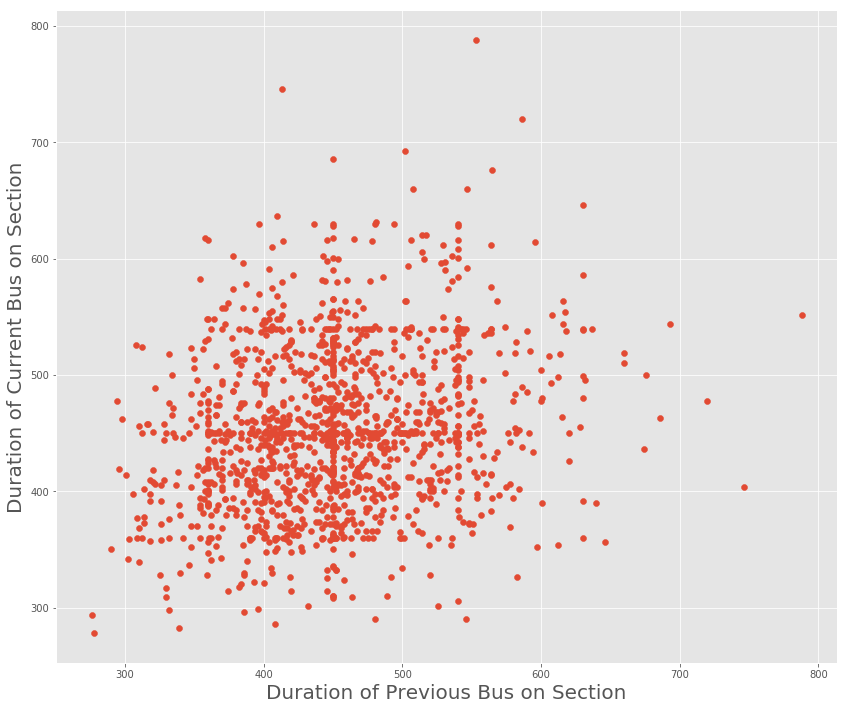

In [24]:
y = prior_trimed_df['seconds_chnk_3'].values.reshape(-1,1)
x = prior_trimed_df['prior_seconds_chnk_3'].values.reshape(-1,1)

fig, ax = plt.subplots(figsize=(14, 12))
ax.scatter(x, y)
ax.set_xlabel("Duration of Previous Bus on Section", fontsize=20)
ax.set_ylabel("Duration of Current Bus on Section", fontsize=20);
plt.savefig('chunk6_current_v_previous.png')